In [1]:
# get all imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss # if you're on mac using miniconda miniforge3 install miniforge::compilers to fix issue with this module
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
# Define data transforms from the Ai_Competition github
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop([224,224]),        # Randomly crop the image to 512x512
        transforms.RandomHorizontalFlip(),        # Randomly flip the image horizontally
        transforms.RandomRotation(180),            # Randomly rotate the image by 10 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, saturation, and hue
        transforms.RandomVerticalFlip(),          # Randomly flip the image vertically
        transforms.ToTensor(),                    # Convert the image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], # Normalize with standard values
                             [0.229, 0.224, 0.225]) # Mean and Std for RGB channels
    ]),
    'augmentation': transforms.Compose([
        transforms.RandomResizedCrop([224,224]),        # Randomly crop the image to 512x512
        transforms.RandomHorizontalFlip(),        # Randomly flip the image horizontally
        transforms.RandomRotation(180),            # Randomly rotate the image by 10 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, saturation, and hue
        transforms.RandomVerticalFlip(),          # Randomly flip the image vertically,                    
        transforms.Normalize([0.485, 0.456, 0.406], # Normalize with standard values
                             [0.229, 0.224, 0.225]) # Mean and Std for RGB channels
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),                    # Resize the image to 512x512
        transforms.ToTensor(),                     # Convert the image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], # Normalize with standard values
                             [0.229, 0.224, 0.225]) # Mean and Std for RGB channels
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),                    # Resize the image to 512x512
        transforms.ToTensor(),                     # Convert the image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], # Normalize with standard values
                             [0.229, 0.224, 0.225]) # Mean and Std for RGB channels
    ])
}

In [5]:
# Create a custom dataset wrapper in order to do train val test splits
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


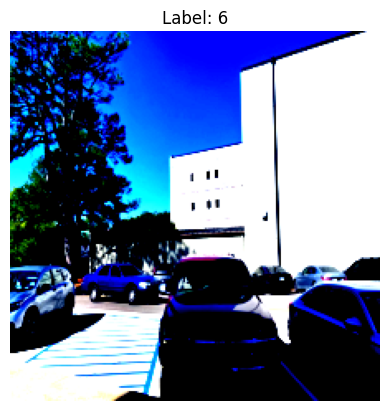

Train dataset size: 7782
Validation dataset size: 370
Test dataset size: 186


In [15]:
batch_size = 32
data_dir = 'AI_Competition'
image_dataset = datasets.ImageFolder(data_dir)



train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

total_size = 0

total_size = len(image_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_size, val_size, test_size])
train_dataset = MyDataset(train_dataset, transform=data_transforms['train'])
val_dataset = MyDataset(val_dataset, transform=data_transforms['val'])
test_dataset = MyDataset(test_dataset, transform=data_transforms['test'])

augmented_datasets = []
augmented_dataset = []
# Create multiple augmented train datasets and concatenate them
for i in range(1, 7):  # Create 6 augmented versions
    augmented_dataset = MyDataset(train_dataset, data_transforms['train'])
    # Concatenate the original dataset with the new augmented one
    augmented_datasets = torch.utils.data.ConcatDataset([augmented_datasets, augmented_dataset])

# Create dataloaders from the concatenated datasets
dataloaders = {
    'train': DataLoader(augmented_datasets, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
}

dataset_sizes = {
    'train': len(augmented_datasets),
    'val': len(val_dataset),
    'test': len(test_dataset)
}


images, labels = next(iter(dataloaders['val']))

# Convert the tensor image to a numpy array for visualization

plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
plt.title(f'Label: {labels[0]}')
plt.axis('off')
plt.show()

print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")
print(f"Test dataset size: {dataset_sizes['test']}")



In [25]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Get the input dimensions of the last layer (fully connected layer)
num_ftrs = model.fc.in_features

# Replace the last layer with a new one that has `num_classes` outputs
model.fc = nn.Linear(num_ftrs, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)
model = model.to(device)

C:\Users\jobc3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jobc3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True
cuda:0


In [26]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 
best_model_wts = model.state_dict()  # Store the best model weights
best_acc = 0.0  # Track the best validation accuracy

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set the model to training mode
        else:
            model.eval()   # Set the model to evaluation mode
        
        running_loss = 0.0  # Track the loss
        running_corrects = 0  # Track the number of correct predictions
        
        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU/CPU
            
            optimizer.zero_grad()  # Clear the gradients
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)  # Forward pass
                _, preds = torch.max(outputs, 1)  # Get the class with the highest score
                loss = criterion(outputs, labels)  # Calculate the loss
                
                if phase == 'train':
                    loss.backward()  # Backpropagate the loss
                    optimizer.step()  # Update the weights
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

print(f'Best val Acc: {best_acc:.4f}')

model.load_state_dict(best_model_wts)

Epoch 0/9
----------
train Loss: 1.1539 Acc: 0.6205
val Loss: 0.2981 Acc: 0.9147
Epoch 1/9
----------
train Loss: 0.4982 Acc: 0.8396
val Loss: 0.1326 Acc: 0.9617
Epoch 2/9
----------
train Loss: 0.3602 Acc: 0.8853
val Loss: 0.0654 Acc: 0.9854
Epoch 3/9
----------
train Loss: 0.2837 Acc: 0.9079
val Loss: 0.0421 Acc: 0.9887
Epoch 4/9
----------
train Loss: 0.2502 Acc: 0.9204
val Loss: 0.0267 Acc: 0.9924
Epoch 5/9
----------
train Loss: 0.2080 Acc: 0.9346
val Loss: 0.0210 Acc: 0.9951
Epoch 6/9
----------
train Loss: 0.1993 Acc: 0.9349
val Loss: 0.0146 Acc: 0.9973
Epoch 7/9
----------
train Loss: 0.1830 Acc: 0.9409
val Loss: 0.0105 Acc: 0.9973
Epoch 8/9
----------
train Loss: 0.1584 Acc: 0.9472
val Loss: 0.0056 Acc: 0.9995
Epoch 9/9
----------
train Loss: 0.1501 Acc: 0.9532
val Loss: 0.0046 Acc: 1.0000
Best val Acc: 1.0000


<All keys matched successfully>

In [27]:
# Evaluate the model on the validation set
model.eval()  # Set model to evaluation mode
all_labels = []
all_preds = []
all_probs = []
running_loss = 0.0
dataloader = dataloaders['val']

with torch.no_grad():
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        
        running_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)  # Get the class with the highest score
        probs = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities
        
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_preds.extend(preds.cpu().numpy())    # Store predicted labels
        all_probs.extend(probs.cpu().numpy())    # Store probabilities

avg_loss = running_loss / len(dataloader.dataset)  # Calculate average loss

# Calculate overall metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
logloss = log_loss(all_labels, all_probs)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Log Loss: {logloss:.4f}')

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Log Loss: 0.0046


C:\Users\jobc3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [28]:
# Finally save the best model!
torch.save(model.state_dict(), "best_model.pth") 